In [893]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_docs.plots
import tensorflow_docs.modeling
import tensorflow_docs as tfdocs

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data Import & Preparation

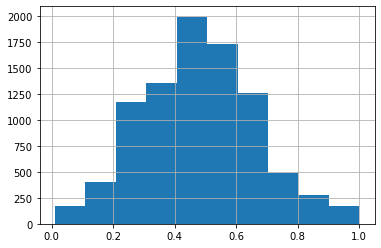

In [894]:
df = pd.read_csv('data.csv').drop_duplicates()
df = df.drop(['raw', 'meditation', 'delta', 'low-gamma', 'mid-gamma'], axis=1)
df.attention = df.attention / 100

df.attention.hist()

In [904]:
df['test'] = df.attention.shift(1)
df

,attention,theta,low-alpha,high-alpha,low-beta,high-beta,log2-theta,log2-low-alpha,log2-high-alpha,log2-low-beta,log2-high-beta,test
attention,1.000000,-0.285365,0.035969,-0.087259,-0.089074,0.365011,-0.325212,-0.043027,-0.057176,-0.033885,0.481352,0.045213
theta,-0.285365,1.000000,0.424622,0.329757,0.274865,0.361964,0.858227,0.344052,0.298341,0.259886,0.286702,-0.022932
low-alpha,0.035969,0.424622,1.000000,0.250096,0.177586,0.566579,0.371596,0.782930,0.228948,0.191102,0.422700,0.000901
high-alpha,-0.087259,0.329757,0.250096,1.000000,0.367293,0.157487,0.346233,0.288256,0.898338,0.352695,0.303354,-0.017504
low-beta,-0.089074,0.274865,0.177586,0.367293,1.000000,0.042244,0.301499,0.274207,0.391299,0.906841,0.271808,-0.016948
high-beta,0.365011,0.361964,0.566579,0.157487,0.042244,1.000000,0.242197,0.296660,0.137508,0.053318,0.687680,0.036544
log2-theta,-0.325212,0.858227,0.371596,0.346233,0.301499,0.242197,1.000000,0.388031,0.356480,0.317396,0.281002,-0.035339
log2-low-alpha,-0.043027,0.344052,0.782930,0.288256,0.274207,0.296660,0.388031,1.000000,0.310309,0.316984,0.376020,-0.015315
log2-high-alpha,-0.057176,0.298341,0.228948,0.898338,0.391299,0.137508,0.356480,0.310309,1.000000,0.432719,0.352368,-0.013607
log2-low-beta,-0.033885,0.259886,0.191102,0.352695,0.906841,0.053318,0.317396,0.316984,0.432719,1.000000,0.339842,-0.036798


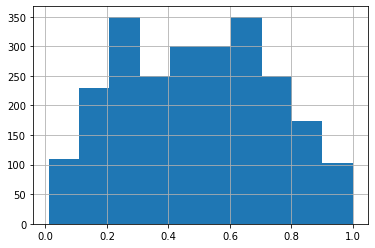

In [896]:
def remove_outliers(df):
    out = pd.DataFrame()
    for att in df.attention.unique():
        tmp_df = df[df.attention == att]
        tmp = []
        for col in tmp_df.columns[1:]:
            Q1 = tmp_df[col].quantile(0.25)
            Q3 = tmp_df[col].quantile(0.75)
            tmp += [(col, Q1, Q3)]
        for col, Q1, Q3 in tmp:
            IQR = Q3 - Q1
            tmp_df = tmp_df[(tmp_df[col] >= Q1 - 0.5 * IQR) & (tmp_df[col] <= Q3 + 0.5 * IQR)]
        out = pd.concat([out, tmp_df])
    return out

def add_features(df):
    for col in df.columns[1:]:
        df[f'log2-{col}'] = np.log2(df[col])
    return df

def prepare_data(df):
    df = remove_outliers(df)
    df = df.sample(frac=1).reset_index(drop=True)
    df = df.groupby(df.attention).head(50)
    df = add_features(df)
    return df

df = prepare_data(df)
df.attention.hist()

In [897]:
def train_val_test_split(df, val_size=0.16, test_size=0.2):
    n = len(df)
    df = df.sample(frac=1).reset_index(drop=True)
    scaler = MinMaxScaler()
    scaler.fit(df.iloc[:, 1:])

    val = df.groupby('attention').apply(lambda x: x.head(int(len(x) * val_size)))
    test = df.groupby('attention').apply(lambda x: x.tail(int(len(x) * test_size)))
    train = pd.concat([df, val, test]).drop_duplicates(keep=False)

    X_train, y_train = train.iloc[:, 1:], train.iloc[:, :1]
    X_val, y_val = val.iloc[:, 1:], val.iloc[:, :1]
    X_test, y_test = test.iloc[:, 1:], test.iloc[:, :1]
    
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1561, 10), (376, 10), (473, 10), (1561, 1), (376, 1), (473, 1))

## Model

In [898]:
def build_model():
    clear_session()
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # optimizer = Adam(1e-2)
    optimizer = RMSprop(1e-2)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [899]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=0)
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), batch_size=16, callbacks=[es, reduce_lr], verbose=2)

Epoch 1/1000
98/98 - 0s - loss: 0.2050 - mae: 0.2050 - mse: 0.0594 - val_loss: 0.1803 - val_mae: 0.1803 - val_mse: 0.0460 - lr: 0.0100
Epoch 2/1000
98/98 - 0s - loss: 0.1858 - mae: 0.1858 - mse: 0.0504 - val_loss: 0.1645 - val_mae: 0.1645 - val_mse: 0.0397 - lr: 0.0100
Epoch 3/1000
98/98 - 0s - loss: 0.1727 - mae: 0.1727 - mse: 0.0449 - val_loss: 0.1553 - val_mae: 0.1553 - val_mse: 0.0360 - lr: 0.0100
Epoch 4/1000
98/98 - 0s - loss: 0.1631 - mae: 0.1631 - mse: 0.0412 - val_loss: 0.1336 - val_mae: 0.1336 - val_mse: 0.0281 - lr: 0.0100
Epoch 5/1000
98/98 - 0s - loss: 0.1586 - mae: 0.1586 - mse: 0.0393 - val_loss: 0.1523 - val_mae: 0.1523 - val_mse: 0.0354 - lr: 0.0100
Epoch 6/1000
98/98 - 0s - loss: 0.1584 - mae: 0.1584 - mse: 0.0386 - val_loss: 0.1486 - val_mae: 0.1486 - val_mse: 0.0354 - lr: 0.0100
Epoch 7/1000
98/98 - 0s - loss: 0.1571 - mae: 0.1571 - mse: 0.0393 - val_loss: 0.1410 - val_mae: 0.1410 - val_mse: 0.0306 - lr: 0.0100
Epoch 8/1000
98/98 - 0s - loss: 0.1562 - mae: 0.1562 - 

Text(0, 0.5, 'Loss (MAE)')

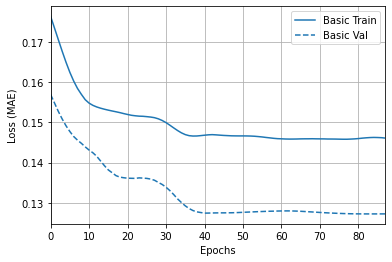

In [900]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric="mae")
plt.ylabel('Loss (MAE)')

## Prediction

In [901]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

15/15 - 0s - loss: 0.1309 - mae: 0.1309 - mse: 0.0288


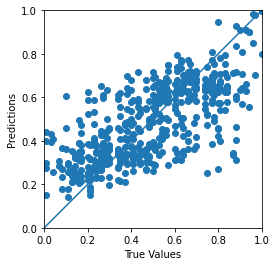

In [902]:
y_pred = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
